Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [225]:
from random import random, seed
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm.auto import tqdm
import torch

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [226]:
UNIVERSE_SIZE = 2000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [227]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

SETS = torch.tensor(SETS, dtype=torch.bool)
COSTS = torch.tensor(COSTS, dtype=torch.float32)

# Move SETS and COSTS to GPU
SETS = SETS.to('cuda')
COSTS = COSTS.to('cuda')


## Helper Functions

In [228]:

def valid(solution: torch.Tensor, SETS: torch.Tensor) -> bool:
    """Checks whether the solution is valid (i.e., covers the entire universe) using PyTorch tensors."""
    selected_sets = SETS[solution]  # Get the sets indexed by the solution
    coverage = torch.any(selected_sets, dim=0)  # Check if any True across rows for each column
    return torch.all(coverage)  # Valid if all columns are covered (i.e., all True)


def cost(solution: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Returns the cost of a solution (to be minimized) using PyTorch tensors."""
    return COSTS[solution].sum()


## Have Fun!

Useful functions, Conversion and tweaking

In [229]:

# Convert np.ndarray to torch.Tensor
def numpy_to_torch_gpu(arr: np.ndarray) -> torch.Tensor:
    return torch.tensor(arr, device='cuda')

# Convert torch.Tensor to np.ndarray
def torch_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    return tensor.cpu().numpy()

def multi_tweak_no_mask(solution: torch.Tensor) -> torch.Tensor:
    new_sol = solution.clone()
    index = None

    while index is None or torch.rand(1).item() < 0.2:
        index = torch.randint(0, NUM_SETS, (1,)).item()
        new_sol[index] = not new_sol[index]
    
    return new_sol

def multi_mutation_tweak(solution: torch.Tensor) -> torch.Tensor:
    """Create a random mask of sets to be flipped and apply it to the solution.
       If the mask is True and the set is already taken -> true to false.
       If the mask is True and the set is not taken -> false to true."""
    
    # Clone the solution tensor to avoid modifying the original
    new_sol = solution.clone()

    # While the new solution is the same as the original, keep generating new solutions
    while torch.all(new_sol == solution):
        mask = torch.rand(NUM_SETS, device=solution.device) < 0.01  # 1% chance of flipping each set
        new_sol = torch.logical_xor(new_sol, mask)  # XOR between solution and mask

    return new_sol

def all_true_solution() -> torch.Tensor:
    """Returns the solution that selects all sets using PyTorch tensors."""
    solution = rng.random(NUM_SETS) < 1  # Generate the initial solution
    solution = numpy_to_torch_gpu(solution)  # Move solution to GPU
    return solution

In [230]:

def fitness(solution: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> tuple:
    """Returns the fitness of a solution using PyTorch tensors"""
    is_valid = valid(solution, SETS)
    solution_cost = -cost(solution, COSTS)
    return (is_valid, solution_cost)

def print_fitness(solution: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor):
    """Prints the fitness of a solution using PyTorch tensors"""
    is_valid, solution_cost = fitness(solution, SETS, COSTS)
    is_valid = is_valid.cpu()
    solution_cost = solution_cost.cpu()
    print(f"Is valid: {is_valid}, Solution cost: {solution_cost}")


Initialization and Plotting Functions


In [231]:
def initialize_solution_and_histories():
    # Vector of all True
    solution = all_true_solution()

    # Initialize history
    full_history = [(-cost(solution, COSTS), 1)]
    bettering_history = [(-cost(solution, COSTS), 1)]

    return solution, full_history, bettering_history

def plot_history(full_history, bettering_history, file_name):
    full_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in full_history]
    bettering_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in bettering_history]
    linspace_full = np.linspace(0, 1, len(full_history_numpy))  # Adjust linspace length for full history
    linspace_bettering = np.linspace(0, 1, len(bettering_history_numpy))  # Adjust linspace length for bettering history
    plt.scatter(linspace_full, full_history_numpy, color='red', s=0.2, label='all')
    plt.plot(linspace_bettering, bettering_history_numpy, color='blue', label='best')
    #build legend
    plt.legend(['all', 'best'])
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost over iterations')
    #plt.savefig(file_name)

def visualize_results(full_history, bettering_history, file_name):
    plot_history(full_history, bettering_history, file_name)
    plt.show()

Random Multi Tweak

In [232]:

def multi_tweak(solution, full_history, bettering_history, NSTEPS) -> \
        tuple[list[tuple[torch.Tensor, int]], list[tuple[torch.Tensor, int]]]:
    print_fitness(solution, SETS, COSTS)
    tweak = multi_mutation_tweak
    last_bettering = 0
    for _ in tqdm(range(int(NSTEPS))):
        new_solution = tweak(solution)
        full_history.append((-cost(solution, COSTS), 1))
        # If new solution is better than the last one, take it
        if fitness(new_solution, SETS, COSTS) > fitness(solution, SETS, COSTS):
            solution = new_solution
            last_bettering = len(full_history)
        bettering_history.append((-cost(solution, COSTS), 1))
    file_name = 'Multi_Tweak_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + \
                 '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
    top_cost = -cost(solution, COSTS).cpu().numpy()
    return full_history, bettering_history, file_name, top_cost, last_bettering


Simulated Annealing With multi random tweaks

In [233]:
def simulated_annealing(solution, full_history, bettering_history, NSTEPS) -> \
        tuple[list[tuple[torch.Tensor, int]], list[tuple[torch.Tensor, int]]]:
    tweak = multi_mutation_tweak
    top_cost = -cost(solution, COSTS)
    last_bettering = 0
    for _ in tqdm(range(int(NSTEPS))):
        new_solution = tweak(solution)
        new_fitness = fitness(new_solution, SETS, COSTS)
        current_fitness = fitness(solution, SETS, COSTS)
        full_history.append((-cost(new_solution, COSTS), 1))
        #if the new solution is better than the current one, accept it
        # else if the acceptance probability is greater than a random number between 0 and 1,
        # accept the new solution
        if new_fitness > current_fitness:
            solution = new_solution
            last_bettering = len(full_history)
            bettering_history.append((-cost(new_solution, COSTS), 1))
        else:
            #put a lower bound on min temperature, that is decreasing with the number of steps
            # from 1 to 0.01
            temperature = max(0.01, 1 - len(full_history) / NSTEPS )
            # Calculate acceptance probability
            # Solution needs to be valid if the starting one was valid
            if(new_fitness[0].cpu().numpy() == current_fitness[0].cpu().numpy or new_fitness[0].cpu().numpy == True):
                acceptance_probability = np.exp((new_fitness[1].cpu().numpy() - current_fitness[1].cpu().numpy()) / temperature)
                if acceptance_probability > rng.random():
                    ic("Accepted worsening solution")
                    top_cost = -cost(solution, COSTS)
                    solution = new_solution
        bettering_history.append((-cost(solution, COSTS), 1))
    if(top_cost < -cost(solution, COSTS)):
        top_cost = -cost(solution, COSTS).cpu().numpy()
    else:
        top_cost = top_cost.cpu().numpy()
    file_name = 'Simulated_Annealing_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
    return full_history, bettering_history, file_name, top_cost, last_bettering

In [234]:

def powered_tweak(solution: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Perform a powered random tweak on the solution."""
    new_sol = solution.clone()
    temp = torch.zeros(NUM_SETS, dtype=torch.bool, device=solution.device)  # Invalid solution (all zeros)

    # Create a random mask of sets to be flipped
    while not valid(temp, SETS):
        mask = torch.rand(NUM_SETS, device=solution.device) < 0.1  # Random mask with probability 0.1
        temp = torch.logical_xor(new_sol, mask)  # Apply XOR between solution and mask

        # If the starting solution is invalid, return the tweaked one anyway
        if not fitness(solution, SETS, COSTS)[0]:
            return temp

    new_sol = temp
    return new_sol
def new_starting_position(last: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Returns a new starting position for the solution by performing powered tweak."""
    # Flip a set with powered_tweak
    new = powered_tweak(last, SETS, COSTS)
    return new
def get_top_maximum(maximums, SETS, COSTS):
    #remove False solutions
    maximums = [x for x in maximums if fitness(x,SETS, COSTS)[0]]
    maximums = sorted(maximums, key=lambda x: -cost(x, COSTS).cpu().numpy(), reverse=True)
    return -cost(maximums[0], COSTS).cpu().numpy()


Iterated Local Search with random multi mutation tweak
Steepest step w n = 3

In [235]:

def iterated_local_search(solution, full_history, bettering_history, MAX_ITERATIONS, NSTEPS) -> \
        tuple[list[tuple[torch.Tensor, int]], list[tuple[torch.Tensor, int]]]:
    CHANGE_STEPS = NSTEPS/MAX_ITERATIONS
    N=3
    CHANGE_COST = 1e-3
    #Iterated Local search
    tweak = multi_mutation_tweak
    change_quantity = []
    change_steps = last_bettering = 0
    top_solution = []
    for _ in tqdm(range(int(NSTEPS/MAX_ITERATIONS))):
        new_solution = [tweak(solution) for _ in range(N)]
        new_solution = sorted(new_solution, key=lambda x: fitness(x, SETS, COSTS), reverse=True)[0]
        full_history.append((-cost(new_solution, COSTS), 1))
        if fitness(new_solution, SETS, COSTS) > fitness(solution, SETS, COSTS):
            solution = new_solution
            last_bettering = len(full_history)
            change_quantity.append(-cost(new_solution, COSTS) + cost(solution, COSTS))
        else:
            change_quantity.append(0)
        change_steps += 1
        # if in last CHANGE_STEPS steps the cost of the solution has not changed
        if change_steps == CHANGE_STEPS:
            if sum(change_quantity) < CHANGE_COST:
                top_solution.append(solution)
                solution = new_starting_position(solution, SETS, COSTS)
                change_quantity = []
                change_steps = 0
            else:
                change_quantity.pop(0)
                change_steps -= 1
        bettering_history.append((-cost(solution, COSTS), 1))
    
    top_solution.append(solution)
    top_cost = get_top_maximum(top_solution, SETS, COSTS)
    file_name = 'Iterated_Local_Search_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
    return full_history, bettering_history, file_name, top_cost, last_bettering


Running main

In [236]:
def task(algorithm: str, MAX_ITERATIONS, NSTEPS):
    # Initialize solution and histories
    solution, full_history, bettering_history = initialize_solution_and_histories()
    # Choose the algorithm
    if algorithm == 'multi_tweak':
        full_history, bettering_history, file_name, top_cost, last_bettering = \
            multi_tweak(solution, full_history, bettering_history, NSTEPS)
    elif algorithm == 'simulated_annealing':
        full_history, bettering_history, file_name, top_cost, last_bettering = \
            simulated_annealing(solution, full_history, bettering_history, NSTEPS)
    elif algorithm == 'iterated_local_search':
        full_history, bettering_history, file_name, top_cost, last_bettering = \
            iterated_local_search(solution, full_history, bettering_history, MAX_ITERATIONS, NSTEPS) 
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")
    

    visualize_results(full_history, bettering_history, file_name)
    return top_cost, last_bettering

In [237]:

#Choose best algorithm for the given configuration
def choose():
    max_iter = 5
    nsteps = 10000
    Multi_tweak_cost, last_mt = task("multi_tweak", max_iter, nsteps)
    Simulated_Annealing_cost, last_sa = task("simulated_annealing", max_iter, nsteps)
    Iterated_Local_Search_cost, last_il = task("iterated_local_search", max_iter, nsteps)

    #Append in choices.txt the best algorithm for the given configuration
    # ex. 100 1000 0.2 -> Multi_tweak
    print(Multi_tweak_cost, Simulated_Annealing_cost, Iterated_Local_Search_cost)
    with open('choices.txt', 'a') as f:
        f.write(f"{UNIVERSE_SIZE} {NUM_SETS} {DENSITY} -> ")
        if Multi_tweak_cost > Simulated_Annealing_cost and Multi_tweak_cost > Iterated_Local_Search_cost:
            f.write("multi_tweak: " + str(last_mt))
        elif Simulated_Annealing_cost > Multi_tweak_cost and Simulated_Annealing_cost > Iterated_Local_Search_cost:
            f.write("simulated_annealing: " + str(last_sa))
        else:
            f.write("iterated_local_search: " + str(last_il))
        f.write("\n")



In [238]:

def get_closer_choice(universe_size, num_sets, density, file_path='choices.txt'):
    # Get closer choice, calculating the difference between the configurations
    with open(file_path, 'r') as file:
        closer_choice = None
        closer_diff = float('inf')
        for line in file:
            parts = line.strip().split(' -> ')
            if len(parts) != 2:
                continue
            config, choice = parts
            config_parts = config.split()
            if len(config_parts) != 3:
                continue
            u_size, n_sets, dens = map(float, config_parts)
            diff = abs(u_size - universe_size) + abs(n_sets - num_sets) + abs(dens - density)*(universe_size)
            if diff < closer_diff:
                closer_diff = diff
                best_config = config_parts
                closer_choice = choice

    algo, iterations = closer_choice.split(': ')
    return algo, int(iterations), best_config

In [239]:
def main():
    algo, iterations, config_vec = get_closer_choice(UNIVERSE_SIZE, NUM_SETS, DENSITY)
    print(f"Algorithm: {algo}, Iterations: {iterations} for {config_vec[0]} {config_vec[1]} {config_vec[2]}")
    iterations += iterations/10
    #use the chosen algorithm
    min_cost, steps = task(algo, 5, iterations)
    print(f"Minimum cost: {min_cost}, Steps: {steps}")


Algorithm: simulated_annealing, Iterations: 9345 for 1000 100 0.2


  0%|          | 0/10279 [00:00<?, ?it/s]

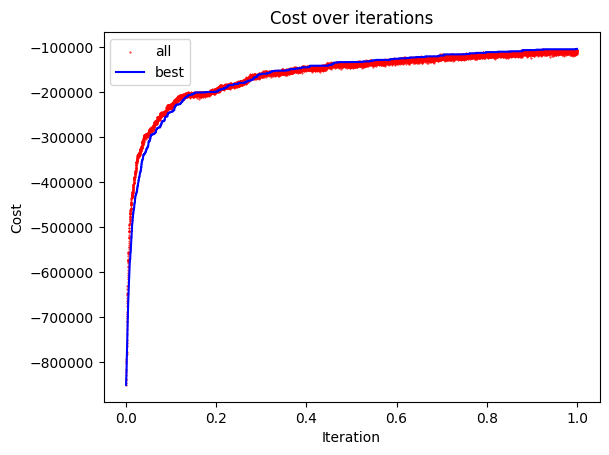

Minimum cost: -104379.515625, Steps: 10250


In [240]:
main()